In [50]:
from drop_lib3 import *
from scipy.io import loadmat
import pickle
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from scipy.signal import periodogram, spectrogram
import matplotlib.pyplot as plt
import numpy as np

directory = 'periodogram' # PSD
directory_to_save(directory)
verbose = 1
data = load_data(verbose=verbose)
speed_labels = data['speed_labels']
volume_labels = data['volume_labels']
unique_speeds = data['unique_speeds']
unique_volumes = data['unique_volumes']


Loaded segments shape: (842, 25000)
Speed labels shape: (842,)
Volume labels shape: (842,)
Unique speeds: [1.72 2.08 2.36 2.64 3.13 3.39 3.42]
Unique volumes: [55 77]


In [51]:
eps = 1e-7
## Spectral feature extraction - periodogram
def extract_periodogram_features(signals, fs=44100, window='boxcar'):
    features = []
    for signal in signals:
        f, Pxx = periodogram(signal, fs=fs, scaling='spectrum', window=window)
        features.append(Pxx)
    return f, np.array(features)


# Extract periodogram features
f, X_periodogram = extract_periodogram_features(data['segments'])
X_periodogram = 10 * np.log10(X_periodogram + eps)
print(f'Periodogram range (dB): [{np.min(X_periodogram.flatten()):.2f}, {np.max(X_periodogram.flatten()):.2f}]')

Periodogram range (dB): [-70.00, -36.01]


In [52]:
number_of_features_to_select = 100
X = X_periodogram

def extract_features_labels(X, y, f, score_func, number_of_features_to_select):
    selector = SelectKBest(score_func, k=number_of_features_to_select)
    X_selected = selector.fit_transform(X, y)
    idx = selector.get_support(indices=True)
    score = selector.scores_[idx]
    idx_sorted = idx[np.argsort(score)][::-1]
    f_scored = f[idx_sorted]
    return X_selected, idx_sorted, score, f_scored

X_speed, idx_speed, score_speed, f_speed = extract_features_labels(X, speed_labels, f, f_classif, number_of_features_to_select)
X_volume, idx_volume, score_volume, f_volume = extract_features_labels(X, volume_labels, f, mutual_info_classif, number_of_features_to_select)

C:\Users\Administrator\anaconda3\envs\sklearn16\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\Administrator\anaconda3\envs\sklearn16\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [53]:
# plot the selected features
# code average periodogram for each class in label
def average_periodogram(X, labels):
    avg_periodograms = []
    for i in range(len(np.unique(labels))):
        avg_periodogram = np.mean(X[labels == i], axis=0)
        avg_periodograms.append(avg_periodogram)
    return np.array(avg_periodograms)

avg_periodograms_speed = average_periodogram(X_periodogram, speed_labels)
avg_periodograms_volume = average_periodogram(X_periodogram, volume_labels)

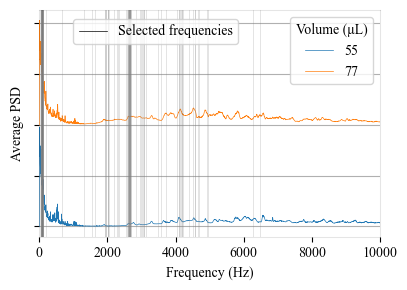

In [75]:
plt.figure(figsize=(4, 3))
plt.plot(f,avg_periodograms_volume[0,:].T, linewidth=0.5)
plt.plot(f,avg_periodograms_volume[1,:].T + 20, linewidth=0.5)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Average PSD')
plt.grid(axis='y')
plt.xlim([-100, np.max(f)])
# remove y tick labels
ax = plt.gca()  # get current axis
ax.set_yticklabels([])  # This removes only the labels
for spine in ax.spines.values():
    spine.set_alpha(0.1)  # Set axes border lines transparency
plt.tight_layout()
# plot vertical lines at the selected frequencies
axvline_handle = plt.axvline(f_volume[0], color='k', linestyle='-', linewidth=.5, label='Selected frequencies')
for freq in f_volume:
    plt.axvline(freq, color='gray', linestyle='-', linewidth=.5, alpha=0.3)
# Create legend with both volume labels and selected frequencies
volume_legend = plt.legend(unique_volumes, title='Volume (\u03BCL)', loc='upper right')
plt.gca().add_artist(volume_legend)  # Keep the volume legend
plt.legend([axvline_handle], ['Selected frequencies'], loc=(0.1, 0.85))
plt.xlim([0, 10e3])
plt.savefig(directory + '/' + 'frequencies_volume.pdf', bbox_inches='tight', transparent=True)
plt.savefig(directory + '/' + 'frequencies_volume.jpeg', dpi=300)
plt.show()

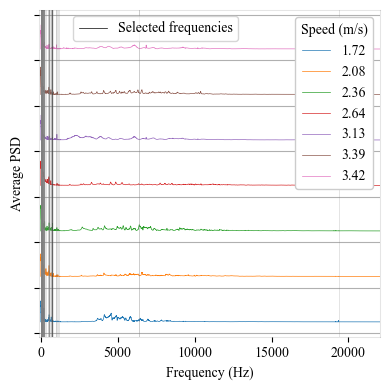

In [77]:
plt.figure(figsize=(4, 4))
plt.plot(f,avg_periodograms_speed[0,:].T*.5, linewidth=0.5)
plt.plot(f,avg_periodograms_speed[1,:].T*.5 + 20, linewidth=0.5)
plt.plot(f,avg_periodograms_speed[2,:].T*.5 + 40, linewidth=0.5)
plt.plot(f,avg_periodograms_speed[3,:].T*.5 + 60, linewidth=0.5)
plt.plot(f,avg_periodograms_speed[4,:].T*.5 + 80, linewidth=0.5)
plt.plot(f,avg_periodograms_speed[5,:].T*.5 + 100, linewidth=0.5)
plt.plot(f,avg_periodograms_speed[6,:].T*.5 + 120, linewidth=0.5)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Average PSD')
plt.grid(axis='y')
plt.xlim([-100, np.max(f)])
# remove y tick labels
ax = plt.gca()  # get current axis
ax.set_yticklabels([])  # This removes only the labels
for spine in ax.spines.values():
    spine.set_alpha(0.1)  # Set axes border lines transparency
# plot vertical lines at the selected frequencies
axvline_handle = plt.axvline(f_speed[0], color='k', linestyle='-', linewidth=.5, label='Selected frequencies')
for freq in f_speed:
    plt.axvline(freq, color='gray', linestyle='-', linewidth=.5, alpha=0.3)
# Create legend with both speed labels and selected frequencies
speed_legend = plt.legend(unique_speeds, title='Speed (m/s)', loc='upper right', framealpha=1.0)
plt.gca().add_artist(speed_legend)  # Keep the speed legend
plt.legend([axvline_handle], ['Selected frequencies'], loc=(0.1, 0.905))
#plt.xlim([0, 10e3])
plt.tight_layout()
plt.savefig(directory + '/' + 'frequencies_speed.pdf', bbox_inches='tight', transparent=True)
plt.savefig(directory + '/' + 'frequencies_speed.jpeg', dpi=300)
plt.show()


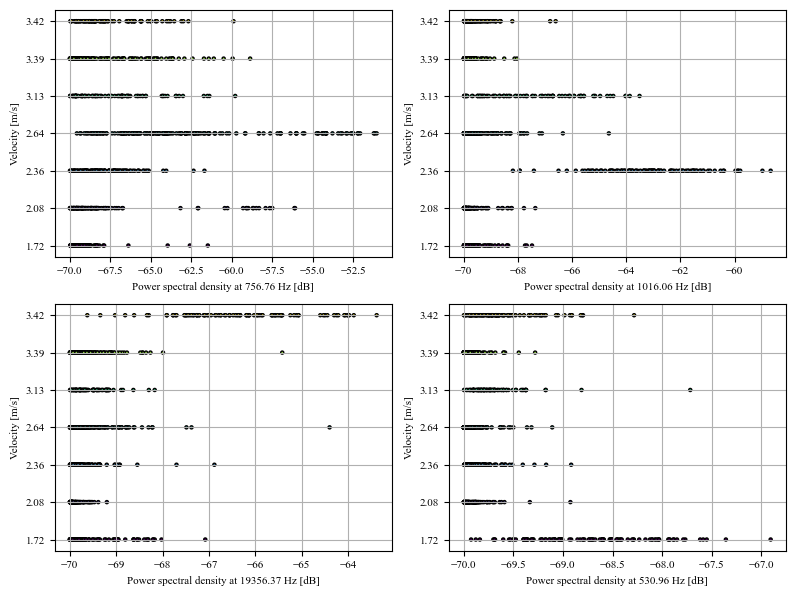

In [56]:
plt.figure(figsize=(8, 6))
plt.style.use('default')
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['font.size'] = 8
for k in range(4):
    feature = X_speed[:, np.argsort(score_speed)[-k]]
    plt.subplot(2, 2, k+1)
    plt.scatter(feature, speed_labels, c=speed_labels, cmap='viridis', edgecolor='k', s=5)
    plt.xlabel(f'Power spectral density at {f_speed[k]:.2f} Hz [dB]')
    plt.ylabel('Velocity [m/s]')
    plt.yticks(ticks=np.arange(0, len(unique_speeds)), labels=unique_speeds)
    plt.grid(True)
plt.tight_layout()
plt.savefig(directory + '/' + 'scatter_plot_speed.pdf', bbox_inches='tight', transparent=True)
plt.savefig(directory + '/' + 'scatter_plot_speed.jpeg', dpi=300)
plt.show()

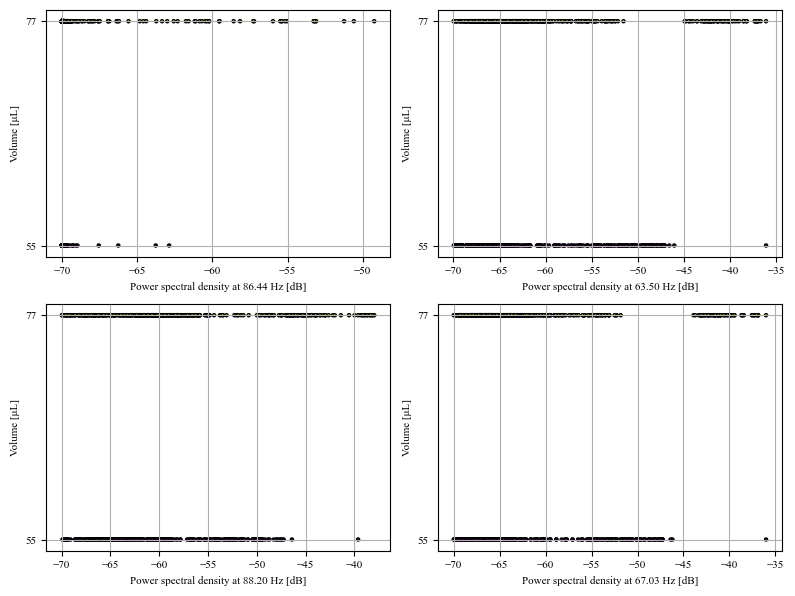

In [57]:
plt.figure(figsize=(8, 6))
plt.style.use('default')
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['font.size'] = 8
for k in range(4):
    feature = X_volume[:, np.argsort(score_volume)[-k]]
    plt.subplot(2, 2, k+1)
    plt.scatter(feature, volume_labels, c=volume_labels, cmap='viridis', edgecolor='k', s=5)
    plt.xlabel(f'Power spectral density at {f_volume[k]:.2f} Hz [dB]')
    plt.ylabel('Volume [μL]')
    plt.yticks(ticks=np.arange(0, len(unique_volumes)), labels=unique_volumes)
    plt.grid(True)
plt.tight_layout()
plt.savefig(directory + '/' + 'scatter_plot_volume.pdf', bbox_inches='tight', transparent=True)
plt.savefig(directory + '/' + 'scatter_plot_volume.jpeg', dpi=300)
plt.show()

In [58]:
# Define the parameter grid for HistGradientBoostingClassifier
param_grid_hgb = {
    'histgradientboostingclassifier__max_iter': [100, 250],
    'histgradientboostingclassifier__max_depth': [10, 50]
}

# Create a pipeline with StandardScaler and HistGradientBoostingClassifier
pipeline_speed = make_pipeline(StandardScaler(), HistGradientBoostingClassifier())
pipeline_volume = make_pipeline(StandardScaler(), HistGradientBoostingClassifier())

# Perform grid search for HistGradientBoostingClassifier
grid_search_hgb_speed = GridSearchCV(pipeline_speed, param_grid_hgb, cv=2, n_jobs=9, verbose=10)
grid_search_hgb_volume = GridSearchCV(pipeline_volume, param_grid_hgb, cv=2, n_jobs=9, verbose=10)
grid_search_hgb_speed.fit(X_speed, speed_labels)
grid_search_hgb_volume.fit(X_volume, volume_labels)
best_hgb_speed_params = grid_search_hgb_speed.best_params_
best_hgb_volume_params = grid_search_hgb_volume.best_params_
print(f'Best parameters for HGB speed: {best_hgb_speed_params}')
print(f'Best parameters for HGB volume: {best_hgb_volume_params}')

Fitting 2 folds for each of 4 candidates, totalling 8 fits
Fitting 2 folds for each of 4 candidates, totalling 8 fits
Best parameters for HGB speed: {'histgradientboostingclassifier__max_depth': 50, 'histgradientboostingclassifier__max_iter': 100}
Best parameters for HGB volume: {'histgradientboostingclassifier__max_depth': 10, 'histgradientboostingclassifier__max_iter': 100}


 20%|██        | 1/5 [00:01<00:04,  1.18s/it]

Velocity accuracy (fold): 0.9704


 40%|████      | 2/5 [00:02<00:03,  1.20s/it]

Velocity accuracy (fold): 0.9822


 60%|██████    | 3/5 [00:03<00:02,  1.24s/it]

Velocity accuracy (fold): 0.9762


 80%|████████  | 4/5 [00:05<00:01,  1.32s/it]

Velocity accuracy (fold): 0.9881


100%|██████████| 5/5 [00:06<00:00,  1.31s/it]


Velocity accuracy (fold): 0.9881
Velocity accuracy average across all folds: 0.9810±0.0069


 20%|██        | 1/5 [00:00<00:01,  2.79it/s]

Volume accuracy (fold): 0.8994


 40%|████      | 2/5 [00:00<00:01,  2.76it/s]

Volume accuracy (fold): 0.9112


 60%|██████    | 3/5 [00:01<00:00,  2.75it/s]

Volume accuracy (fold): 0.8869


 80%|████████  | 4/5 [00:01<00:00,  2.77it/s]

Volume accuracy (fold): 0.9226


100%|██████████| 5/5 [00:01<00:00,  2.80it/s]

Volume accuracy (fold): 0.9226
Volume accuracy average across all folds - : 0.9086±0.0138
Results saved in directory: ./periodogram/
[[103   0   0   0   0   0   0]
 [  0 120   0   2   0   0   0]
 [  0   0 112   1   0   0   0]
 [  0   1   0 180   0   1   0]
 [  0   0   0   0  87   0   1]
 [  0   0   1   4   0 137   0]
 [  0   0   0   0   5   0  87]]
[[331  38]
 [ 39 434]]


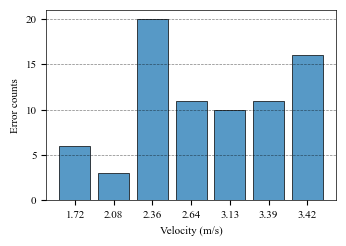

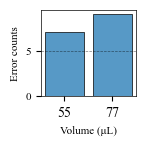

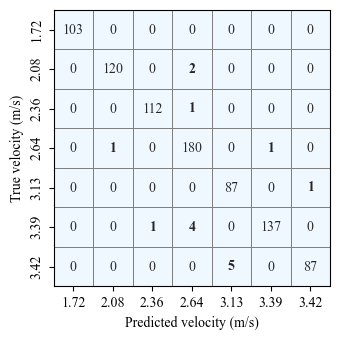

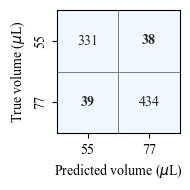

In [59]:
# Train the models with the best parameters
best_hgb_speed = make_pipeline(HistGradientBoostingClassifier(**{k.split('__')[1]: v for k, v in best_hgb_speed_params.items()}))
best_hgb_volume = make_pipeline(HistGradientBoostingClassifier(**{k.split('__')[1]: v for k, v in best_hgb_volume_params.items()}))

confusion_matrices_speed, error_indices_speed, all_cv_scores_speed, \
confusion_matrices_volume, error_indices_volume, all_cv_scores_volume\
    = evaluate_classifier(best_hgb_speed, best_hgb_volume, X_speed, X_volume, data, random_state=42)
save_results(confusion_matrices_speed, error_indices_speed, all_cv_scores_speed,
             confusion_matrices_volume, error_indices_volume, all_cv_scores_volume,
             data,
             directory=directory, verbose=verbose)
plot_results(confusion_matrices_speed, error_indices_speed,
             confusion_matrices_volume, error_indices_volume,
             data,
             directory=directory, verbose=verbose)